In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
import os
from glob import glob
import PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.applications.vgg16 import VGG16
from keras import models
from keras.models import Model
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from tensorflow.keras import layers
import pathlib 

%matplotlib inline

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Define paths 
train_path = '/content/drive/My Drive/Deep Learning/train/Train'
validation_path = '/content/drive/My Drive/Deep Learning/train/Validation'
test_path = '/content/drive/My Drive/Deep Learning/test'

In [ ]:
#Import and process data 
size=100
target_size = (100, 100)
batch_size = 128
mode = 'binary'

train_datagen = ImageDataGenerator(rescale = 1./255)

validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size = (size, size),
    batch_size = batch_size,
    class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size = (size, size),
    batch_size = batch_size, 
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (size, size),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 11136 images belonging to 2 classes.
Found 1279 images belonging to 2 classes.
Found 27167 images belonging to 2 classes.


In [ ]:
#Subset testset to reduce prediction time 
datagen = ImageDataGenerator(validation_split = 0.2, rescale = 1./255)
subset_test_generator = datagen.flow_from_directory(
    test_path,
    target_size = (size, size),
    batch_size = batch_size,
    subset = 'validation')

Found 5432 images belonging to 2 classes.


In [ ]:
#Create baseline model 
baseline_model = tf.keras.models.Sequential([
                             tf.keras.layers.Conv2D(16,(3,3), activation = 'relu', input_shape = (100,100,3)),
                             tf.keras.layers.MaxPooling2D((2,2)),
                             tf.keras.layers.Conv2D(16,(3,3), activation = 'relu'),
                             tf.keras.layers.MaxPooling2D((2,2)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(64, activation = 'relu'),
                             tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
#Baseline model summary 
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8464)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                541760    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [ ]:
#Define loss function, optimizer and metrics 
baseline_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
#Train model 
batch_size = 1280
history = baseline_model.fit(train_generator,steps_per_epoch = 11136 //batch_size ,epochs=10,
                              validation_data = validation_generator,validation_steps = 1279  //120)

Epoch 1/10
8/8 [==============================] - 601s 81s/step - loss: 0.8069 - accuracy: 0.5059 - val_loss: 0.6734 - val_accuracy: 0.6075
Epoch 2/10
8/8 [==============================] - 241s 30s/step - loss: 0.6945 - accuracy: 0.4678 - val_loss: 0.6899 - val_accuracy: 0.5324
Epoch 3/10
8/8 [==============================] - 209s 26s/step - loss: 0.6844 - accuracy: 0.5889 - val_loss: 0.6680 - val_accuracy: 0.6091
Epoch 4/10
8/8 [==============================] - 189s 24s/step - loss: 0.6743 - accuracy: 0.5439 - val_loss: 0.6528 - val_accuracy: 0.6724
Epoch 5/10
8/8 [==============================] - 171s 21s/step - loss: 0.6559 - accuracy: 0.6777 - val_loss: 0.6204 - val_accuracy: 0.6505
Epoch 6/10
8/8 [==============================] - 157s 19s/step - loss: 0.6259 - accuracy: 0.6738 - val_loss: 0.6118 - val_accuracy: 0.6833
Epoch 7/10
8/8 [==============================] - 134s 17s/step - loss: 0.5910 - accuracy: 0.7100 - val_loss: 0.5888 - val_accuracy: 0.6732
Epoch 8/10
8/8 [====

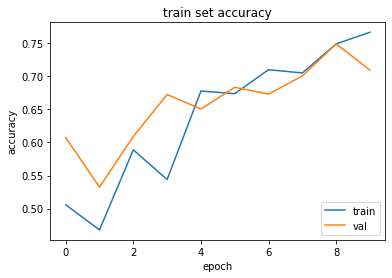

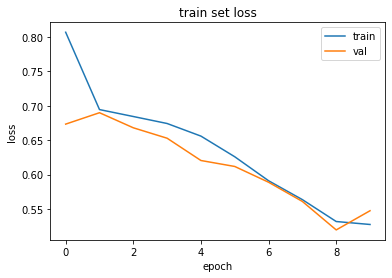

In [ ]:
#Plot Training and Validation accuracy + Training and Validation loss 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('train set accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
#Evaluate score on test set 
history = baseline_model.evaluate(subset_test_generator)
print('test loss, test acc:', history)

43/43 [==============================] - 1156s 28s/step - loss: 0.9186 - accuracy: 0.5000
test loss, test acc: [0.9186455011367798, 0.5]


In [ ]:
#Subtract labels and predictions from test set 
Y_pred = baseline_model.predict_generator(subset_test_generator)
y_pred = []
for i in Y_pred:
  if i <= 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)
print(y_pred)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 

In [ ]:
#Create confusion matrix 
cf_matrix = confusion_matrix(subset_test_generator.classes, y_pred)
print(cf_matrix)

[[ 941  956]
 [1807 1728]]


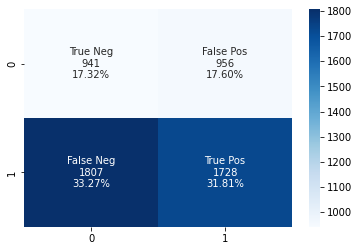

In [ ]:
#Improve confusion matrix 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [ ]:
#Improve confusion matrix 
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

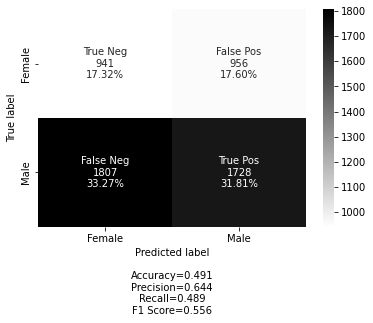

In [ ]:
#Improved confusion matrix with performance measures 
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ["Female", "Male"]
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

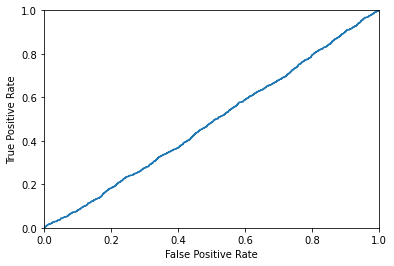

0.4857454523221732


In [ ]:
#Plot ROC with AUC score 
fpr , tpr , thresholds = roc_curve (subset_test_generator.classes, Y_pred)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 
auc_score=roc_auc_score(subset_test_generator.classes, Y_pred)
print(auc_score)

In [ ]:
#Define variables for data import improved model 
batch_size = 32
img_height = 100
img_width = 100

In [ ]:
#Import train, validation and test set 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/My Drive/Deep Learning/train/Train',
  seed=123,
  image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/My Drive/Deep Learning/train/Validation',
  seed=123,
  image_size=(img_height, img_width))

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/My Drive/Deep Learning/test',
  seed=123,
  image_size=(img_height, img_width))

Found 11136 files belonging to 2 classes.
Found 1279 files belonging to 2 classes.
Found 27167 files belonging to 2 classes.


In [ ]:
#Define class names 
class_names = train_ds.class_names
print(class_names)

['Female', 'Male']


In [ ]:
#Speeding up the process
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Rescale images for CNN 
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

normalized_dsval = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

normalized_test = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0
0.0 1.0


In [ ]:
#Data augmentation to improve models performance 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
#Improved model 
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
#Define loss function, optimizer and metrics 
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
#Summary of improved model 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 100, 100, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 64)       

In [ ]:
#Training the model 
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
348/348 [==============================] - 129s 368ms/step - loss: 0.5523 - accuracy: 0.7109 - val_loss: 0.5021 - val_accuracy: 0.7428
Epoch 2/10
348/348 [==============================] - 126s 363ms/step - loss: 0.4533 - accuracy: 0.7910 - val_loss: 0.3448 - val_accuracy: 0.8546
Epoch 3/10
348/348 [==============================] - 126s 362ms/step - loss: 0.4015 - accuracy: 0.8199 - val_loss: 0.3326 - val_accuracy: 0.8640
Epoch 4/10
348/348 [==============================] - 126s 362ms/step - loss: 0.3668 - accuracy: 0.8370 - val_loss: 0.3158 - val_accuracy: 0.8780
Epoch 5/10
348/348 [==============================] - 126s 361ms/step - loss: 0.3471 - accuracy: 0.8475 - val_loss: 0.2644 - val_accuracy: 0.8952
Epoch 6/10
348/348 [==============================] - 126s 361ms/step - loss: 0.3260 - accuracy: 0.8609 - val_loss: 0.2859 - val_accuracy: 0.8999
Epoch 7/10
348/348 [==============================] - 125s 360ms/step - loss: 0.3050 - accuracy: 0.8677 - val_loss: 0.2512 -

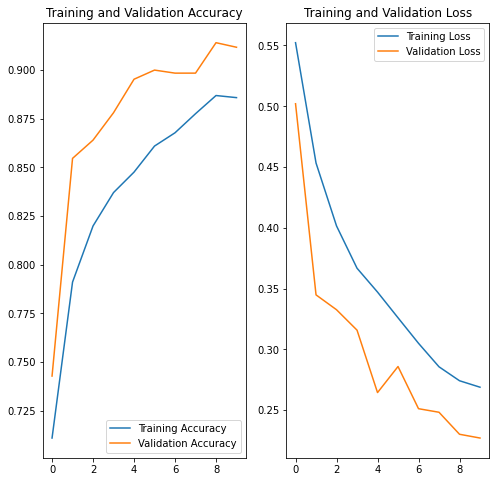

In [ ]:
#Plot Training and Validation accuracy + Training and Validation loss 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('figure_1.png')
plt.show()

In [ ]:
#Evaluate score on test set 
history = model.evaluate(test_ds)
print('test loss, test acc:', history)

40/40 [==============================] - 4s 96ms/step - loss: 0.2270 - accuracy: 0.9116
test loss, test acc: [0.22704166173934937, 0.9116497039794922]


In [ ]:
#Subtract labels and predictions from test set 
Y_pred = model.predict_generator(test_ds)

y_pred = []
for i in Y_pred:
  if i <= 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)
print(y_pred)

Y = []
for x, y in test_ds:
  for i in y:
    if i == 1:
      Y.append(1)
    if i == 0:
      Y.append(0)
print(Y)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 

In [ ]:
#Create confusion matrix 
cf_matrix = confusion_matrix(Y, y_pred)
print(cf_matrix)

[[442  60]
 [ 53 724]]


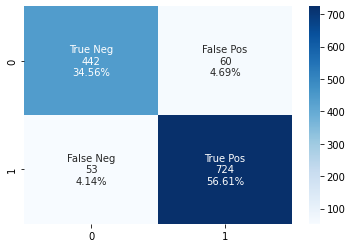

In [ ]:
#Improve confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

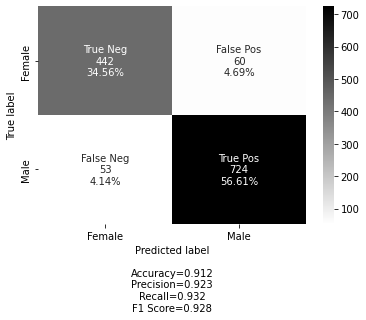

In [ ]:
#Improved confusion matrix with performance measures 
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ["Female", "Male"]
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

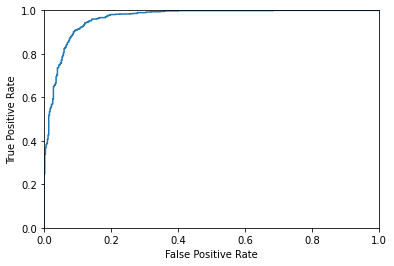

0.9641241981879431


In [ ]:
#Plot ROC with AUC score 
fpr , tpr , thresholds = roc_curve (Y, Y_pred)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 
auc_score=roc_auc_score(Y, Y_pred)
print(auc_score)

In [ ]:
#Modeling VGG16
vgg_model = VGG16(input_shape = (100, 100, 3), include_top = False, weights = "imagenet")

#Freezing the layers
for layer in vgg_model.layers:
    layer.trainable = False
    
top_model = vgg_model.output
top_model = layers.Flatten(name="flatten")(top_model)
top_model = layers.Dense(128, activation='relu')(top_model)
output_layer = layers.Dense(2, activation='sigmoid')(top_model)

#Transfering the model
transfer_model = Model(inputs=vgg_model.input, outputs=output_layer)

#Applying Adam optimizer
transfer_model.compile(optimizer='adam', loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 15
transfer_history = transfer_model.fit(
  normalized_ds,
  validation_data=normalized_dsval,
  epochs=epochs
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


348/348 [==============================] - 1209s 3s/step - loss: 0.3783 - accuracy: 0.8305 - val_loss: 0.2787 - val_accuracy: 0.8812
Epoch 2/15
348/348 [==============================] - 1206s 3s/step - loss: 0.2858 - accuracy: 0.8770 - val_loss: 0.2792 - val_accuracy: 0.8921
Epoch 3/15
348/348 [==============================] - 1206s 3s/step - loss: 0.2642 - accuracy: 0.8868 - val_loss: 0.2898 - val_accuracy: 0.8851
Epoch 4/15
348/348 [==============================] - 1203s 3s/step - loss: 0.2355 - accuracy: 0.9006 - val_loss: 0.2843 - val_accuracy: 0.8882
Epoch 5/15
348/348 [==============================] - 1208s 3s/step - loss: 0.2190 - accuracy: 0.9083 - val_loss: 0.2797 - val_accuracy: 0.8921
Epoch 6/15
348/348 [==============================] - 1213s 3s/step - loss: 0.1992 - accuracy: 0.9155 - val_loss: 0.3266 - val_accuracy: 0.8788
Epoch 7/15
348/348 [==============================] - 1212s 3s/step - loss: 0.1747 - accuracy: 0.9298 - val_loss: 0.3324 - val_accuracy: 0.8757
Epo

KeyboardInterrupt: ignored

In [ ]:
#Evaluate score on test set 
history = transfer_model.evaluate(normalized_test)
print('test loss, test acc:', history)

In [ ]:
#Subtract labels and predictions from test set 
Y_pred = model.predict_generator(normalized_test)

y_pred = []
for i in Y_pred:
  if i <= 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)
print(y_pred)

Y = []
for x, y in normalized_test:
  for i in y:
    if i == 1:
      Y.append(1)
    if i == 0:
      Y.append(0)
print(Y)

In [ ]:
#Create confusion matrix 
cf_matrix = confusion_matrix(Y, y_pred)
print(cf_matrix)

In [ ]:
#Improve confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [ ]:
#Improved confusion matrix with performance measures 
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ["Female", "Male"]
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

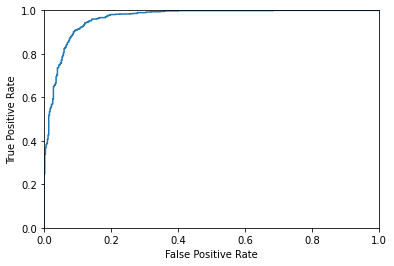

0.9641241981879431


In [ ]:
#Plot ROC with AUC score 
fpr , tpr , thresholds = roc_curve (Y, Y_pred)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 
auc_score=roc_auc_score(Y, Y_pred)
print(auc_score)